<a href="https://colab.research.google.com/github/tilacyn/ir-itmo/blob/master/AntispamStatsSeminarMultiprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ** Описание **

Построить графики распределения в спам и не спам множествах следующих признаков:

1	Количество слов на странице
2	Средняя длинна слова
3	Количество слов в заголовке страниц (слова в теге <html><head><title> Some text </title>)
4	Количество слов в анкорах ссылок (<html><body><a> Some text </a>)
5	Коэффициент сжатия

Нужно посчитать статистику минимум по трем признакам и обязательно сделать для 1-го и 2-го признаков

И отправить первое решение в соревнование https://kaggle.com/join/antispam_infopoisk
На основании одного из указанных выше признаков попытаться разделить мн-во, так чтобы score в соревновании был больше 0.55

При выполнении всех этих условия в течении семинара +1 балл к ДЗ

Описание ДЗ и правил выставления за него баллов в https://inclass.kaggle.com/c/antispam-infopoisk  
Сроки ДЗ уточнить у преподователя - обычно 2 недели

In [0]:
from __future__ import division

import base64
import csv
import gzip
import zlib

from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
TRACE_NUM = 1000
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)
        
def trace_worker(items_num, worker_id, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d in worker_id %d" % (items_num, worker_id))

### Утилиты

#### Декораторы

In [0]:
def to_utf8(text):
    if isinstance(text, unicode): text = text.encode('utf8')
    return text

def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, unicode): text = text.decode('utf8')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [0]:
from HTMLParser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()

@convert2unicode
def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text()

#### Извлечение текста при помощи дополнительных библиотек

In [0]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [0]:
#html2text = html2text_bs
html2text = html2text_parser

#### Методы для токенизации текста

In [0]:
@convert2lower
@convert2unicode
def easy_tokenizer(text):
    word = unicode()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = unicode()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

@convert2lower
@convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [0]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    return tokenizer(to_text(raw_html).lower())

#### Рассчет финальных метрик

In [0]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print 'threshold %s' % threshold
            print '\tclass_prec %s, class_recall %s, class_F1 %s' % r[0]
            print '\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1]
            print '\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2)
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [0]:
def calc_features(url, html_data):
    words = list(html2word(html_data))
    words_num = len(words)
    avg_word_len = 0
    title_words_num = 0    
    anchor_words_num = 0
    compression_level = 0
    
    return [len(words), avg_word_len, title_words_num, anchor_words_num, compression_level]

In [13]:
test_html_data = u'''
<html>
<title> Заголовок Ololo </title>
спам 1 2 3
</html>
'''
test_url = 'http://ololo'
test_features = calc_features(test_url, test_html_data)
print test_features

[6, 0, 0, 0, 0]


In [0]:
from multiprocessing import Process, Queue

DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

WORKER_NUM = 4

def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            features = calc_features_f(url, html_data)            
            yield DocItem(url_id, mark, url, features)            
                
        trace(i, 1)  
        
def load_csv_worker(input_file_name, calc_features_f, worker_id, res_queue):    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace_worker(i, worker_id)
            if i % WORKER_NUM != worker_id: continue
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            features = calc_features_f(url, html_data)            
            res_queue.put(DocItem(url_id, mark, url, features))
                
        trace_worker(i, worker_id, 1)  
    res_queue.put(None)
        
def load_csv_multiprocess(input_file_name, calc_features_f):
    processes = []
    res_queue = Queue()    
    for i in xrange(WORKER_NUM):
        process = Process(target=load_csv_worker, args=(input_file_name, calc_features_f, i, res_queue))
        processes.append(process)
        process.start()
    
    complete_workers = 0
    while complete_workers != WORKER_NUM:
        item = res_queue.get()
        if item is None:
            complete_workers += 1
        else:
            yield item
        
    for process in processes: process.join()

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [15]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/antispam-ir-itmo')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Plots

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


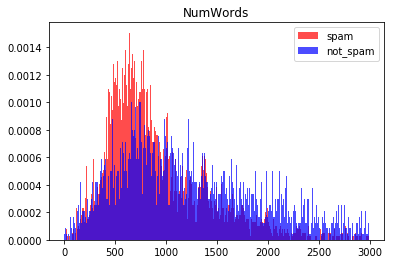

In [0]:
is_spam_data = [doc.features[0] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWords')
plt.legend()
plt.show()

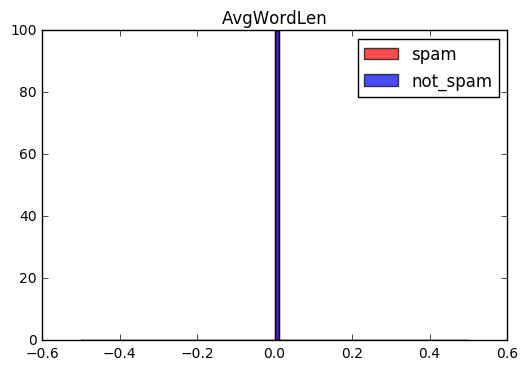

In [0]:
is_spam_data = [doc.features[1] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[1] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('AvgWordLen')
plt.legend()
plt.show()

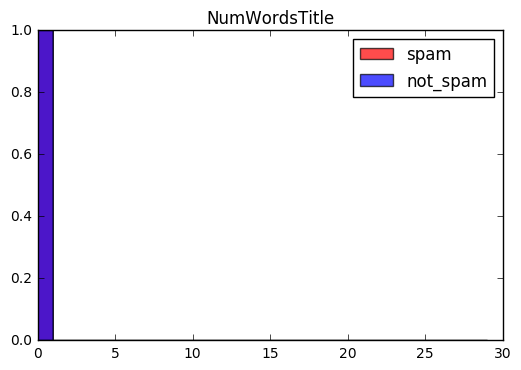

In [0]:
is_spam_data = [doc.features[2] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[2] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWordsTitle')
plt.legend()
plt.show()

In [0]:
#Добавить графики для остальных фичей

#### Классификатор: реализовать

In [16]:
%%time
TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv.gz'
TEST_DATA_FILE  = 'kaggle_test_data_tab.csv.gz'

gen = load_csv_multiprocess(TRAIN_DATA_FILE, lambda x, y: y)
train_and_val_docs = list(gen)
gen = load_csv_multiprocess(TEST_DATA_FILE, lambda x, y: y)
submission_docs = list(gen)

13:05:40 INFO:Complete items 00000 in worker_id 1
13:05:40 INFO:Complete items 00000 in worker_id 0
13:05:40 INFO:Complete items 00000 in worker_id 2
13:05:40 INFO:Complete items 00000 in worker_id 3
13:05:42 INFO:Complete items 01000 in worker_id 2
13:05:42 INFO:Complete items 01000 in worker_id 3
13:05:42 INFO:Complete items 01000 in worker_id 0
13:05:42 INFO:Complete items 01000 in worker_id 1
13:05:44 INFO:Complete items 02000 in worker_id 0
13:05:44 INFO:Complete items 02000 in worker_id 3
13:05:44 INFO:Complete items 02000 in worker_id 2
13:05:44 INFO:Complete items 02000 in worker_id 1
13:05:45 INFO:Complete items 03000 in worker_id 0
13:05:45 INFO:Complete items 03000 in worker_id 3
13:05:45 INFO:Complete items 03000 in worker_id 1
13:05:45 INFO:Complete items 03000 in worker_id 2
13:05:47 INFO:Complete items 04000 in worker_id 0
13:05:47 INFO:Complete items 04000 in worker_id 3
13:05:47 INFO:Complete items 04000 in worker_id 2
13:05:47 INFO:Complete items 04000 in worker_id 1


CPU times: user 1 s, sys: 1.85 s, total: 2.85 s
Wall time: 40.5 s


In [0]:
def extract_features_from_corpus(docs):
    tf_idf_vector = TfidfVectorizer(min_df=0.05, sublinear_tf=True).fit_transform([d.features for d in docs]).toarray()
    result = []
    for doc_num, doc in enumerate(docs):
      result.append(DocItem(doc.doc_id, doc.is_spam, doc.url, tf_idf_vector[doc_num]))
    return result

In [0]:
train_docs = train_and_val_docs[:6000]
val_docs = train_and_val_docs[6000:]
all_docs = train_and_val_docs + submission_docs
all_docs_featured = extract_features_from_corpus(all_docs)
train_docs_featured = all_docs_featured[:len(train_docs)]
val_docs_featured = all_docs_featured[len(train_docs):len(train_docs) + len(val_docs)]
submission_docs_features = all_docs_featured[len(train_docs) + len(val_docs):]

In [0]:
from six.moves import urllib
from sklearn import svm
import math
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier

In [0]:
idf_cache = {}

def tf(term, text):
  return text[term] / text[-1]

def idf(term, corpus):
  if term not in idf_cache:
    idf_cache[term] = math.log(len(corpus) / len([_ for doc in corpus if term in doc]))
  return idf_cache[term]

def to_dict(text):
  res = dict()
  for term in text:
    res.setdefault(term, 0)
    res[term] += 1
  res[-1] = sum(res.values())
  return res

def extract_features_tfidf(text, corpus, nf):
  tf_idf = {}
  for term in text:
    if term in tf_idf:
      continue
    tf_idf[term] = tf(term, text) * idf(term, corpus)
  
  features = tf_idf.values()
  features.sort()
  return features[-nf:]

def extract_features(url, html):
  text = html2word(html, to_text=html2text_bs_visible)
  text = [word for word in text]
  text_dict = to_dict(text)
  avg_word_len = np.mean([len(word) for word in text])
  # print(url)

  return len(text), len(text_dict), avg_word_len, len(url.split('-'))

In [0]:
class Classifier:
    
    def __init__(self, nf):
        self.model = XGBClassifier(max_depth=4, learning_rate=0.1, n_estimators=700)
        pass

    def predict_all(self, docs):
        return self.model.predict([doc.features for doc in docs])
    
    def train(self, docs):           
        objects = [doc.features for doc in docs]
        labels = [doc.is_spam for doc in docs]
        objects = np.array(objects)
        labels = np.array(labels)
        self.model.fit(objects, labels)

def eval(preds, docs):
  p = 0
  n = 0
  tp = 0
  tn = 0
  for doc, ypred in zip(docs, preds):
    ytrue = doc.is_spam
    p += ytrue
    tp += ytrue and ypred
    n += not ytrue
    tn += not ytrue and not ypred
  return tp, tn, p, n

In [0]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

class Classifier2:
    
    def __init__(self, nf):
        # self.model = OneVsRestClassifier(SVC())
        self.model = SVC()
        pass

    def predict_all(self, docs):
        return self.model.predict([doc.features for doc in docs])
    
    def train(self, docs):           
        objects = [doc.features for doc in docs]
        labels = [doc.is_spam for doc in docs]
        objects = np.array(objects)
        labels = np.array(labels)
        self.model.fit(objects, labels)


In [0]:
classifier = Classifier(2)
classifier.train(val_docs_featured + train_docs_featured)

In [86]:
preds = classifier.predict_all(val_docs_featured)
tp, tn, p, n = eval(preds, val_docs_featured)
print(tp / p)
print(tn / n)

1.0
1.0


In [0]:
classifier = Classifier2(2)
classifier.train(train_docs_featured[:100])

In [83]:
preds = classifier.predict_all(train_docs_featured[:100])
tp, tn, p, n = eval(preds, train_docs_featured[:100])
print(tp / p)
print(tn / n)

1.0
0.0


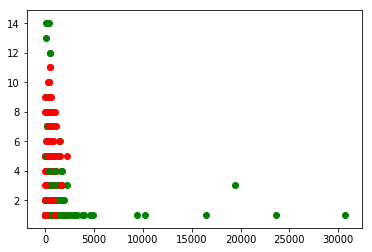

In [78]:
for doc in train_docs[:1000]:
  l = doc.is_spam
  o = doc.features
  if l == True:
    color = 'red'
  else:
    color = 'green'
  plt.scatter(o[1], o[3], color=color)
# plt.xlim(0, 2000)
# plt.ylim(0, 2000)
plt.show()

In [0]:
with open('submission.csv', 'wb') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    batch_size = 500
    for i in range(len(submission_docs) // batch_size + 1):
      current_submission_docs = submission_docs_features[i * batch_size:(i + 1) * batch_size]
      
      if len(current_submission_docs) == 0:
        break
      predictions = classifier.predict_all(current_submission_docs)
      for doc, pred in zip(current_submission_docs, predictions):
          # prediction =  1 if item[3] > threshold else 0
          writer.writerow([doc.doc_id, int(pred)])